# Assignment 3

> Tristan PERROT

## Utils

### Imports


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import trange

DATASET_PATH = '../Dataset/' # 'datasets/CIFAR-10/' #

In [2]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
def load_batch(filename):
    """ Copied from the dataset website """
    import pickle
    with open(DATASET_PATH + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_data(filename):
    """ Read the data from the file """
    data = load_batch(filename)
    X = data[b'data'].T / 255
    y = np.array(data[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1
    return X, Y, y


def load_all_data():
    """ Load all the data """
    X, Y, y = load_data('data_batch_1')
    for i in range(2, 6):
        X_i, Y_i, y_i = load_data(f'data_batch_{i}')
        X = np.concatenate((X, X_i), axis=1)
        Y = np.concatenate((Y, Y_i), axis=1)
        y = np.concatenate((y, y_i))
    X_test_, Y_test_, y_test_ = load_data('test_batch')
    return X, Y, y, X_test_, Y_test_, y_test_

In [4]:
def compute_relative_error(grad_analytical, grad_numerical, eps=1e-9):
    """ Compute the relative error between the analytical and numerical gradients """
    return torch.max(
        torch.abs(grad_analytical - grad_numerical) / torch.clamp(
            torch.abs(grad_analytical) + torch.abs(grad_numerical) + eps, min=eps))

## Exercises

### Model


In [5]:
def compute_eta(eta_min, eta_max, t, n_s):
    t = t % (2 * n_s)
    if t < n_s:
        return eta_min + t / n_s * (eta_max - eta_min)
    else:
        return eta_max - (t - n_s) / n_s * (eta_max - eta_min)


class Classifier:
    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_1d_train, y_1d_val, y_1d_test, eta=0.001,
                 lambda_=0.0, device='cpu'):
        self.device = device

        self.x_train = torch.tensor(
            x_train, dtype=torch.float64).to(self.device)
        self.x_val = torch.tensor(x_val, dtype=torch.float64).to(self.device)
        self.x_test = torch.tensor(x_test, dtype=torch.float64).to(self.device)
        self.y_train = torch.tensor(
            y_train, dtype=torch.float64).to(self.device)
        self.y_val = torch.tensor(y_val, dtype=torch.float64).to(self.device)
        self.y_test = torch.tensor(y_test, dtype=torch.float64).to(self.device)
        self.y_1d_train = torch.tensor(
            y_1d_train, dtype=torch.float64).to(self.device)
        self.y_1d_val = torch.tensor(
            y_1d_val, dtype=torch.float64).to(self.device)
        self.y_1d_test = torch.tensor(
            y_1d_test, dtype=torch.float64).to(self.device)

        self.eta = eta
        self.lambda_ = lambda_

        self.costs_train = []
        self.costs_val = []
        self.losses_train = []
        self.losses_val = []
        self.accuracies_train = []
        self.accuracies_val = []

    def keep_n_data(self, n):
        self.x_train = self.x_train[:, :n]
        self.y_train = self.y_train[:, :n]
        self.y_1d_train = self.y_1d_train[:n]
        self.x_val = self.x_val[:, :n]
        self.y_val = self.y_val[:, :n]
        self.y_1d_val = self.y_1d_val[:n]
        self.x_test = self.x_test[:, :n]
        self.y_test = self.y_test[:, :n]
        self.y_1d_test = self.y_1d_test[:n]

    def keep_n_dim(self, n):
        self.x_train = self.x_train[:n]
        self.x_val = self.x_val[:n]
        self.x_test = self.x_test[:n]
        self.y_val = self.y_val[:n]
        self.y_train = self.y_train[:n]
        self.y_test = self.y_test[:n]
        self.y_1d_train = self.y_1d_train[:n]
        self.y_1d_val = self.y_1d_val[:n]
        self.y_1d_test = self.y_1d_test[:n]

    def preprocess(self):
        mean_X = torch.mean(self.x_train, dim=1, keepdim=True)
        std_X = torch.std(self.x_train, dim=1, keepdim=True)
        self.x_train = (self.x_train - mean_X) / std_X
        self.x_val = (self.x_val - mean_X) / std_X
        self.x_test = (self.x_test - mean_X) / std_X

    def initialize_weights(self, hidden_sizes):
        n_layers = len(hidden_sizes) + 1
        features = self.x_train.shape[0]
        outputs = self.y_train.shape[0]
        self.W = []
        self.b = []
        for i in range(n_layers):
            if i == 0:
                self.W.append(torch.randn(hidden_sizes[i], features, dtype=torch.float64, requires_grad=True).to(
                    self.device) / math.sqrt(features))
                self.b.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
            elif i == n_layers - 1:
                self.W.append(torch.randn(outputs, hidden_sizes[i - 1], dtype=torch.float64, requires_grad=True).to(
                    self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(
                    outputs, 1, dtype=torch.float64, requires_grad=True).to(self.device))
            else:
                self.W.append(torch.randn(hidden_sizes[i], hidden_sizes[i - 1], dtype=torch.float64,
                              requires_grad=True).to(self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))

    def forward(self, x, W, b):
        self.x_list = [x]
        self.s_list = []
        for l in range(len(W)):
            s = W[l] @ self.x_list[l] + b[l]
            self.s_list.append(s)
            if l == len(W) - 1:
                self.p = torch.softmax(s, dim=0)
            else:
                h = torch.relu(s)
                self.x_list.append(h)

    def cost(self, x, y, W, b):
        m = x.shape[1]
        self.forward(x, W, b)
        loss = -torch.sum(y * torch.log(self.p)) / m
        reg = self.lambda_ * sum(torch.sum(w**2) for w in W)
        return loss + reg, loss

    def cost_grad(self, x, y):
        m = x.shape[1]
        self.forward(x, self.W, self.b)
        grad_W = [torch.zeros_like(w) for w in self.W]
        grad_b = [torch.zeros_like(bi) for bi in self.b]

        g = -(y - self.p)

        for l in range(len(self.W) - 1, -1, -1):
            grad_W[l] = g @ self.x_list[l].T / m + 2 * self.lambda_ * self.W[l]
            grad_b[l] = torch.sum(g, dim=1, keepdim=True) / m
            if l > 0:
                g = (self.W[l].T @ g) * (self.s_list[l - 1] > 0)

        return grad_W, grad_b

    def accuracy(self, x, y):
        self.forward(x, self.W, self.b)
        correct = torch.sum(torch.argmax(y, dim=0) ==
                            torch.argmax(self.p, dim=0))
        return correct.item() / x.shape[1]

    def compute_grads_num(self, X, Y, W, b, h):
        grad_W = [torch.zeros_like(w) for w in W]
        grad_b = [torch.zeros_like(bi) for bi in b]

        c, _ = self.cost(X, Y, W, b)

        for j in range(len(b)):
            for i in range(len(b[j])):
                b_try = [bi.clone() for bi in b]
                b_try[j][i] += h
                c2, _ = self.cost(X, Y, W, b_try)
                grad_b[j][i] = (c2 - c) / h
        for j in range(len(W)):
            for i in range(np.prod(W[j].shape)):
                W_try = [wi.clone() for wi in W]
                idx = np.unravel_index(i, W[j].shape)
                W_try[j][idx] += h
                c2, _ = self.cost(X, Y, W_try, b)
                grad_W[j][idx] = (c2 - c) / h

        return grad_W, grad_b

    def check_grad(self):
        grad_W, grad_b = self.cost_grad(self.x_train, self.y_train)

        grad_W_num, grad_b_num = self.compute_grads_num(
            self.x_train, self.y_train, self.W, self.b, 1e-5)

        print('Between analytical and numerical gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_num[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_num[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_num[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_num[i]).item() for i in range(len(grad_b))])

        cost, _ = self.cost(self.x_train, self.y_train,
                            self.W, self.b)
        for i in range(len(self.W)):
            self.W[i].retain_grad()
            self.b[i].retain_grad()
        cost.backward()
        grad_W_autograd = [w.grad for w in self.W]
        grad_b_autograd = [b.grad for b in self.b]

        print('\nBetween analytical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])

        print('\nBetween numerical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W_num[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b_num[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W_num[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b_num[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])

        for i in range(len(self.W)):
            self.W[i].grad.zero_()
            self.b[i].grad.zero_()

    def mini_batch_gd(self, batch_size, n_epochs):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        p_bar = trange(n_epochs)
        for epoch in p_bar:
            shuffle_idx = torch.randperm(n)
            x_train = self.x_train[:, shuffle_idx]
            y_train = self.y_train[:, shuffle_idx]
            for i in range(n_batch):
                start = i * batch_size
                end = min((i + 1) * batch_size, n)
                x_batch = x_train[:, start:end]
                y_batch = y_train[:, start:end]
                grad_W, grad_b = self.cost_grad(x_batch, y_batch)
                with torch.no_grad():
                    for l in range(len(self.W)):
                        self.W[l] -= self.eta * grad_W[l]
                        self.b[l] -= self.eta * grad_b[l]
            cost_train, loss_train = self.cost(
                self.x_train, self.y_train, self.W, self.b)
            cost_val, loss_val = self.cost(
                self.x_val, self.y_val, self.W, self.b)
            self.costs_train.append(cost_train.item())
            self.costs_val.append(cost_val.item())
            self.losses_train.append(loss_train.item())
            self.losses_val.append(loss_val.item())
            accuracy_train = self.accuracy(self.x_train, self.y_train)
            accuracy_val = self.accuracy(self.x_val, self.y_val)
            self.accuracies_train.append(accuracy_train)
            self.accuracies_val.append(accuracy_val)
            p_bar.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {
                                  cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epochs}')

    def mini_batch_gd_cyclic(self, batch_size, n_s, n_cycles, pbar=True):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        n_epoch = math.ceil(2 * n_s / n_batch)
        t = 0
        p_bar = trange(n_cycles) if pbar else range(n_cycles)
        for cycle in p_bar:
            p_bar.set_description(
                f'Cycle: {cycle + 1}/{n_cycles}') if pbar else None
            p_bar2 = trange(n_epoch, leave=False) if pbar else range(n_epoch)
            for epoch in p_bar2:
                shuffle_idx = torch.randperm(n)
                x_train = self.x_train[:, shuffle_idx]
                y_train = self.y_train[:, shuffle_idx]
                for i in range(n_batch):
                    start = i * batch_size
                    end = min((i + 1) * batch_size, n)
                    x_batch = x_train[:, start:end]
                    y_batch = y_train[:, start:end]
                    grad_W, grad_b = self.cost_grad(x_batch, y_batch)
                    self.eta = compute_eta(1e-5, 1e-1, t, n_s)
                    with torch.no_grad():
                        for l in range(len(self.W)):
                            self.W[l] -= self.eta * grad_W[l]
                            self.b[l] -= self.eta * grad_b[l]
                    t += 1
                cost_train, loss_train = self.cost(
                    self.x_train, self.y_train, self.W, self.b)
                cost_val, loss_val = self.cost(
                    self.x_val, self.y_val, self.W, self.b)
                self.costs_train.append(cost_train.item())
                self.costs_val.append(cost_val.item())
                self.losses_train.append(loss_train.item())
                self.losses_val.append(loss_val.item())
                accuracy_train = self.accuracy(self.x_train, self.y_train)
                accuracy_val = self.accuracy(self.x_val, self.y_val)
                self.accuracies_train.append(accuracy_train)
                self.accuracies_val.append(accuracy_val)
                p_bar2.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {
                                       cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epoch}') if pbar else None

    def plot_costs_acc(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].plot(self.costs_train, label='Train')
        ax[0].plot(self.costs_val, label='Validation')
        ax[0].set_title('Cost vs Epochs')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Cost')
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(self.losses_train, label='Train')
        ax[1].plot(self.losses_val, label='Validation')
        ax[1].set_title('Loss vs Epochs')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[1].legend()
        ax[1].grid()
        ax[2].plot(self.accuracies_train, label='Train')
        ax[2].plot(self.accuracies_val, label='Validation')
        ax[2].set_title('Accuracy vs Epochs')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Accuracy')
        ax[2].legend()
        ax[2].grid()
        fig.tight_layout()
        print('Train Accuracy:', self.accuracies_train[-1])
        print('Validation Accuracy:', self.accuracies_val[-1])
        print('Test Accuracy:', self.accuracy(self.x_test, self.y_test))
        plt.show()

## Exercise 1


In [6]:
X_train, Y_train, y_train = load_data('data_batch_1')
X_val, Y_val, y_val = load_data('data_batch_2')
X_test, Y_test, y_test = load_data('test_batch')

n = 20
dim = 50

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.001, lambda_=0.0, device=device)
classifier.keep_n_data(n)
classifier.keep_n_dim(dim)
classifier.preprocess()
classifier.initialize_weights([50])
classifier.check_grad()

classifier.initialize_weights([50, 20])
classifier.check_grad()

classifier.initialize_weights([50, 20, 15])
classifier.check_grad()

Between analytical and numerical gradients:
Biggest difference for W for every layer: [1.182914074332464e-07, 4.2964795487730745e-06]
Biggest difference for b for every layer: [9.778965990095423e-08, 6.054254557824601e-07]
Biggest relative error for W for every layer: [0.006961443718620352, 0.00022686982859639545]
Biggest relative error for b for every layer: [0.00015333899759159832, 4.676303181016058e-05]

Between analytical and autograd gradients:
Biggest difference for W for every layer: [2.0816681711721685e-17, 5.551115123125783e-17]
Biggest difference for b for every layer: [6.938893903907228e-18, 1.1275702593849246e-17]
Biggest relative error for W for every layer: [1.5270555033703288e-12, 7.641114146035804e-15]
Biggest relative error for b for every layer: [1.2746539342241574e-14, 1.151566346866122e-15]

Between numerical and autograd gradients:
Biggest difference for W for every layer: [1.182914074332464e-07, 4.296479548755727e-06]
Biggest difference for b for every layer: [9.7

## Exercise 2


In [7]:
X, Y, y, X_test, Y_test, y_test = load_all_data()
n_train = 45000
X_train, X_val = X[:, :n_train], X[:, n_train:]
Y_train, Y_val = Y[:, :n_train], Y[:, n_train:]
y_train, y_val = y[:n_train], y[n_train:]

n_batch = 100
batch_size = n_train // n_batch

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.005, device=device)
classifier.preprocess()
classifier.initialize_weights([50, 50])
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=5 * batch_size, n_cycles=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Accuracy: 0.5888222222222222
Validation Accuracy: 0.5414
Test Accuracy: 0.5323


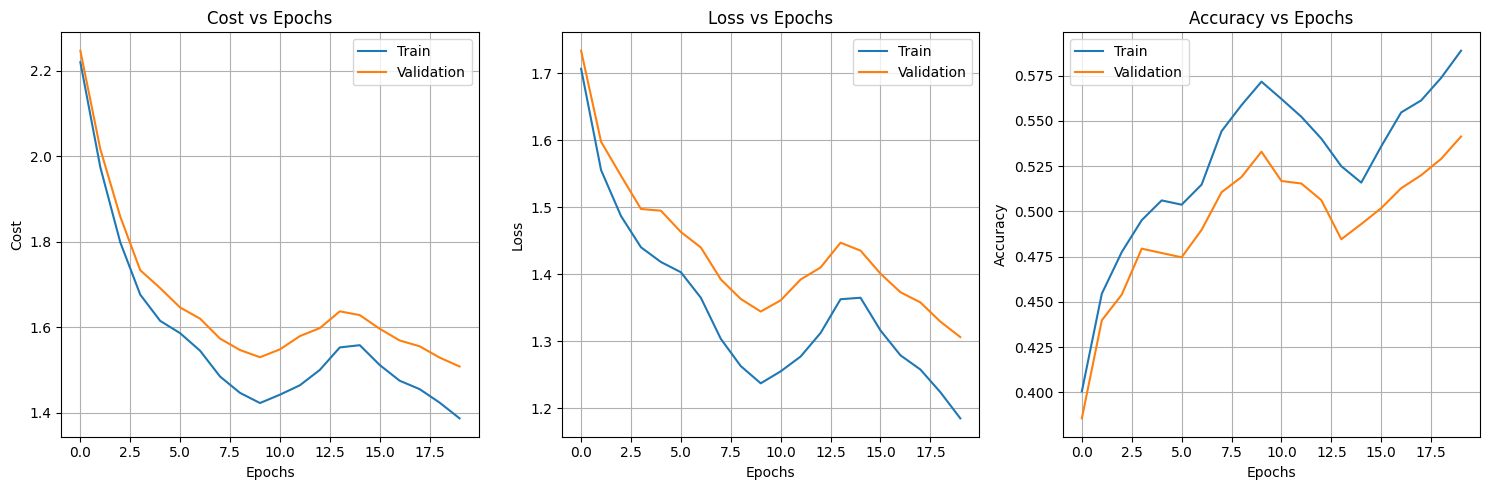

In [8]:
classifier.plot_costs_acc()

In [9]:
classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.005, device=device)
classifier.preprocess()
classifier.initialize_weights([50, 30, 20, 20, 10, 10, 10, 10])
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=5 * batch_size, n_cycles=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Accuracy: 0.4292888888888889
Validation Accuracy: 0.3914
Test Accuracy: 0.3898


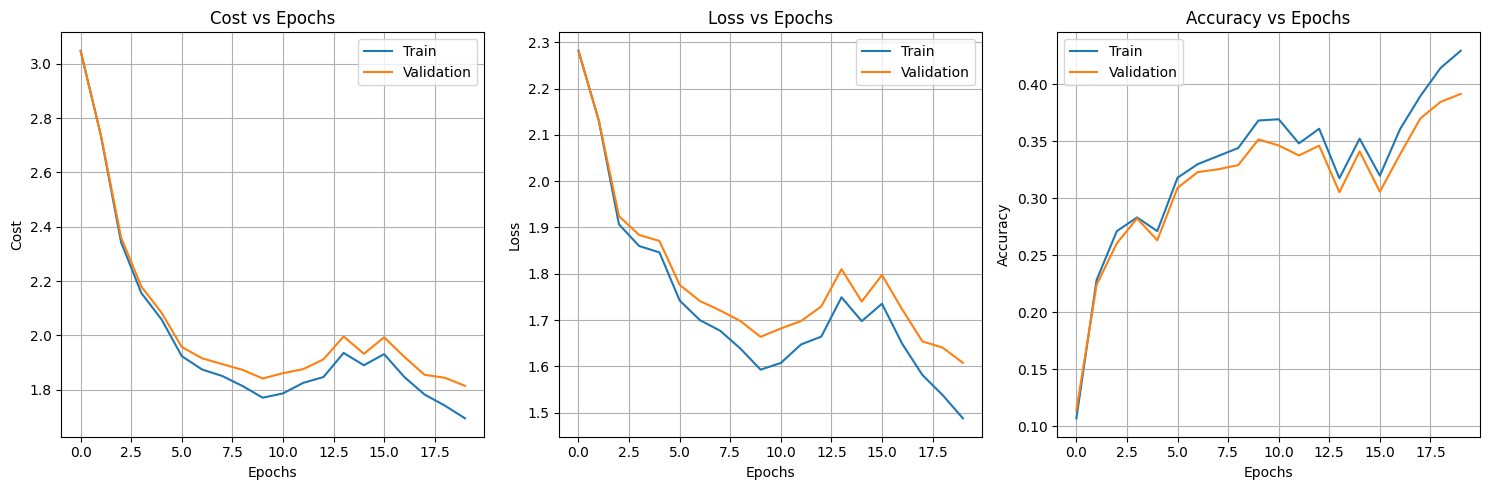

In [10]:
classifier.plot_costs_acc()

## Exercise 3

In [25]:
class ClassifierBN(Classifier):
    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_1d_train, y_1d_val, y_1d_test, eta=0.001,
                 lambda_=0.0, device='cpu'):
        super().__init__(x_train, x_val, x_test, y_train, y_val, y_test,
                         y_1d_train, y_1d_val, y_1d_test, eta, lambda_, device)

    def initialize_weights(self, hidden_sizes):
        n_layers = len(hidden_sizes) + 1
        features = self.x_train.shape[0]
        outputs = self.y_train.shape[0]
        self.W = []
        self.b = []
        self.gamma = []
        self.beta = []
        for i in range(n_layers):
            if i == 0:
                self.W.append(torch.randn(hidden_sizes[i], features, dtype=torch.float64, requires_grad=True).to(
                    self.device) / math.sqrt(features))
                self.b.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.gamma.append(torch.ones(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.beta.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
            elif i == n_layers - 1:
                self.W.append(torch.randn(outputs, hidden_sizes[i - 1], dtype=torch.float64, requires_grad=True).to(
                    self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(
                    outputs, 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.gamma.append(torch.ones(
                    outputs, 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.beta.append(torch.zeros(
                    outputs, 1, dtype=torch.float64, requires_grad=True).to(self.device))
            else:
                self.W.append(torch.randn(hidden_sizes[i], hidden_sizes[i - 1], dtype=torch.float64,
                              requires_grad=True).to(self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.gamma.append(torch.ones(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
                self.beta.append(torch.zeros(
                    hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))

    def forward(self, x, W, b, eps=1e-9):
        self.x_list = [x]
        self.s_list = []
        self.s_hat_list = []
        self.mean_list = []
        self.var_list = []
        self.p_list = []
        for l in range(len(W)):
            s = W[l] @ self.x_list[l] + b[l]
            self.s_list.append(s)
            if l == len(W) - 1:
                self.p = torch.softmax(s, dim=0)
            else:
                mean = torch.mean(s, dim=1, keepdim=True)
                var = torch.var(s, dim=1, keepdim=True, correction=0)
                s_hat = (s - mean) / torch.sqrt(var + eps)
                s_tilde = self.gamma[l] * s_hat + self.beta[l]
                self.mean_list.append(mean)
                self.var_list.append(var)
                self.s_hat_list.append(s_hat)
                self.x_list.append(torch.relu(s_tilde))

    def cost_grad(self, x, y, eps=1e-9):
        n = x.shape[1]
        self.forward(x, self.W, self.b)

        grad_W = [torch.zeros_like(w) for w in self.W]
        grad_b = [torch.zeros_like(bi) for bi in self.b]
        grad_gamma = [torch.zeros_like(self.gamma[i])
                      for i in range(len(self.gamma) - 1)]
        grad_beta = [torch.zeros_like(self.beta[i])
                     for i in range(len(self.beta) - 1)]

        one_n = torch.ones((n, 1), dtype=torch.float64).to(self.device)

        g = -(y - self.p)
        grad_W[-1] = g @ self.x_list[-1].T / n + 2 * self.lambda_ * self.W[-1]
        grad_b[-1] = g @ one_n / n
        g = (self.W[-1].T @ g) * (self.x_list[-1] > 0)

        for l in range(len(self.W) - 2, -1, -1):
            grad_gamma[l] = (g * self.s_hat_list[l]) @ one_n / n
            grad_beta[l] = g @ one_n / n
            g *= self.gamma[l] @ one_n.T
            temp = self.var_list[l] + eps
            sigma1 = torch.pow(temp, -.5)
            sigma2 = torch.pow(temp, -1.5)
            g1 = g * (sigma1 @ one_n.T)
            g2 = g * (sigma2 @ one_n.T)
            d = self.s_list[l] - self.mean_list[l] @ one_n.T
            c = (g2 * d) @ one_n
            g = g1 - (g1 @ one_n) @ one_n.T / n - d * (c @ one_n.T) / n

            grad_W[l] = g @ self.x_list[l].T / n + 2 * self.lambda_ * self.W[l]
            grad_b[l] = g @ one_n / n
            if l > 0:
                g = (self.W[l].T @ g) * (self.x_list[l] > 0)

        return grad_W, grad_b, grad_gamma, grad_beta

    def mini_batch_gd_BN_cyclic(self, batch_size, n_s, n_cycles, pbar=True):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        n_epoch = math.ceil(2 * n_s / n_batch)
        t = 0
        p_bar = trange(n_cycles) if pbar else range(n_cycles)
        for cycle in p_bar:
            p_bar.set_description(
                f'Cycle: {cycle + 1}/{n_cycles}') if pbar else None
            p_bar2 = trange(n_epoch, leave=False) if pbar else range(n_epoch)
            for epoch in p_bar2:
                shuffle_idx = torch.randperm(n)
                x_train = self.x_train[:, shuffle_idx]
                y_train = self.y_train[:, shuffle_idx]
                for i in range(n_batch):
                    start = i * batch_size
                    end = min((i + 1) * batch_size, n)
                    x_batch = x_train[:, start:end]
                    y_batch = y_train[:, start:end]
                    grad_W, grad_b = self.cost_grad(x_batch, y_batch)
                    self.eta = compute_eta(1e-5, 1e-1, t, n_s)
                    with torch.no_grad():
                        for l in range(len(self.W)):
                            self.W[l] -= self.eta * grad_W[l]
                            self.b[l] -= self.eta * grad_b[l]
                    t += 1
                cost_train, loss_train = self.cost(
                    self.x_train, self.y_train, self.W, self.b)
                cost_val, loss_val = self.cost(
                    self.x_val, self.y_val, self.W, self.b)
                self.costs_train.append(cost_train.item())
                self.costs_val.append(cost_val.item())
                self.losses_train.append(loss_train.item())
                self.losses_val.append(loss_val.item())
                accuracy_train = self.accuracy(self.x_train, self.y_train)
                accuracy_val = self.accuracy(self.x_val, self.y_val)
                self.accuracies_train.append(accuracy_train)
                self.accuracies_val.append(accuracy_val)
                p_bar2.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {
                                       cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epoch}') if pbar else None

    def check_grad(self):
        grad_W, grad_b, grad_gamma, grad_beta = self.cost_grad(
            self.x_train, self.y_train)

        grad_W_num, grad_b_num = self.compute_grads_num(
            self.x_train, self.y_train, self.W, self.b, 1e-5)

        print('Between analytical and numerical gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_num[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_num[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_num[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_num[i]).item() for i in range(len(grad_b))])

        cost, _ = self.cost(self.x_train, self.y_train,
                            self.W, self.b)
        for i in range(len(self.W)):
            self.W[i].retain_grad()
            self.b[i].retain_grad()
            self.gamma[i].retain_grad()
            self.beta[i].retain_grad()
        cost.backward()
        grad_W_autograd = [w.grad for w in self.W]
        grad_b_autograd = [b.grad for b in self.b]
        grad_gamma_autograd = [g.grad for g in self.gamma]
        grad_beta_autograd = [b.grad for b in self.beta]

        print('\nBetween analytical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest difference for gamma for every layer:', [torch.max(
            torch.abs(grad_gamma[i] - grad_gamma_autograd[i])).item() for i in range(len(grad_gamma))])
        print('Biggest difference for beta for every layer:', [torch.max(
            torch.abs(grad_beta[i] - grad_beta_autograd[i])).item() for i in range(len(grad_beta))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])
        print('Biggest relative error for gamma for every layer:', [compute_relative_error(
            grad_gamma[i], grad_gamma_autograd[i]).item() for i in range(len(grad_gamma))])
        print('Biggest relative error for beta for every layer:', [compute_relative_error(
            grad_beta[i], grad_beta_autograd[i]).item() for i in range(len(grad_beta))])

        print('\nBetween numerical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W_num[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b_num[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W_num[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b_num[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])

        for i in range(len(self.W)):
            self.W[i].grad.zero_()
            self.b[i].grad.zero_()

In [27]:
X_train, Y_train, y_train = load_data('data_batch_1')
X_val, Y_val, y_val = load_data('data_batch_2')
X_test, Y_test, y_test = load_data('test_batch')

n = 20
dim = 60

classifier = ClassifierBN(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.001, lambda_=0.005, device=device)
classifier.keep_n_data(n)
classifier.keep_n_dim(dim)
classifier.preprocess()
classifier.initialize_weights([50])
classifier.check_grad()

Between analytical and numerical gradients:
Biggest difference for W for every layer: [4.623395710612321e-06, 6.484258088246264e-07]
Biggest difference for b for every layer: [4.440892653612138e-11, 6.51169006556096e-07]
Biggest relative error for W for every layer: [0.004625939013961025, 0.013720605693485998]
Biggest relative error for b for every layer: [0.04252063095956837, 4.743747763724432e-05]

Between analytical and autograd gradients:
Biggest difference for W for every layer: [6.245004513516506e-17, 5.551115123125783e-17]
Biggest difference for b for every layer: [3.191891195797325e-17, 2.7755575615628914e-17]
Biggest difference for gamma for every layer: [1.3877787807814457e-17]
Biggest difference for beta for every layer: [2.0816681711721685e-17]
Biggest relative error for W for every layer: [4.667031598182562e-13, 2.6045182930493903e-13]
Biggest relative error for b for every layer: [3.191891093915634e-08, 1.4871296006188596e-15]
Biggest relative error for gamma for every la